# Learning and Decision Making

## Laboratory 1: Markov chains

In the end of the lab, you should export the notebook to a Python script (File >> Download as >> Python (.py)). Your file should be named `padi-lab1-groupXX.py`, where the `XX` corresponds to your group number and should be submitted to the e-mail <adi.tecnico@gmail.com>. 

Make sure...

* **... that the subject is of the form `[<group n.>] LAB <lab n.>`.** 

* **... to strictly respect the specifications in each activity, in terms of the intended inputs, outputs and naming conventions.** 

In particular, after completing the activities you should be able to replicate the examples provided (although this, in itself, is no guarantee that the activities are correctly completed).

### 1. The Markov chain model

Consider once again the shuttle modeling problem described in the Homework and for which you wrote a Markov chain model:

<img src="shuttle.png" width="800px">

Recall that your chain should describe the motion of the single shuttle traveling the network, where: 

* All stops are considered similar, in terms of shuttle behavior;
* At each moment, there is a single shuttle traversing the city;
* When at I.S.T. TagusPark, the shuttle will go directly to Sete Rios with a probability of 70%, and to Oeiras with a 30% probability. Similarly, when at Sete Rios, the shuttle will go directly to I.S.T. Alameda with a 50% probability, and through Praça de Londres with a 50% probability.

In this first activity, you will implement your Markov chain model in Python. You should label the different shuttle stops as `'0'`, `'1'`, `'2'`, `'3'`, `'4'` (note that these are strings), from left to right in the diagram above. For example, "I.S.T. TagusPark" corresponds to `'0'`, while "Praça de Londres" corresponds to `'3'`.

---

#### Activity 1.        

Write a function named `load_chain` that receives **no input arguments** and returns, as output, a two-element tuple corresponding to the Markov chain, where:

* ... the first element is a tuple containing an enumeration of the state-space (i.e., each element of the tuple corresponds to a state of the chain, represented as a string).
* ... the second element is a `numpy` array corresponding to the transition probability matrix for the chain.

**Note**: Don't forget to import `numpy`.

---

In [1]:
import numpy as np

def load_chain():
    return (('0', '1', '2', '3', '4'), 
            np.array([[0, 0.3, 0.7, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0.5, 0.5], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]))

We provide below an example of application of the function, that you can use as a first "sanity check" for your code. Note, however, that the fact that you can replicate the examples below is not indicative that your code is correct.

```python
print('Number of states:', len(M[0]))
print('Type of states:', type(M[0][0]))
print('\nTransition probability matrix (type):', type(M[1]))
print('Transition probability matrix (dimension):', M[1].shape)
```

Output:
```
Number of states: 5
Type of states: <class 'str'>

Transition probability matrix (type): <class 'numpy.ndarray'>
Transition probability matrix (dimension): (5, 5)
 ```

In the next activity, you will use the Markov chain model to evaluate the likelihood of any given path for the bot.

---

#### Activity 2.

Write a function `prob_trajectory` that receives, as inputs, 

* ... a Markov chain in the form of a tuple like the one returned by the function in Activity 1;
* ... a trajectory, corresponding to a sequence of states (i.e., a tuple or list of strings, each string corresponding to a state).

Your function should return, as output, a floating point number corresponding to the probability of observing the provided trajectory, taking the first state in the trajectory as initial state. 

---

In [2]:
def prob_trajectory(markov, trajectory):
    prob = 1
    for x in range(len(trajectory)):
        if x-1 < 0:
            continue
        actual = markov[0].index(trajectory[x])
        prev = markov[0].index(trajectory[x-1])
        prob = markov[1][prev][actual] * prob
    
    return prob

Example of application of the function with the chain $M$ from Activity 1.

```python
print('Prob. of trajectory (1, 2, 3):', prob_trajectory(M, ('1', '2', '3')))
print('Prob. of trajectory (4, 0, 1, 2, 3):', prob_trajectory(M, ('4', '0', '1', '2', '3')))
print('Prob. of trajectory (4, 0, 4):', prob_trajectory(M, ('4', '0', '4')))
print('Prob. of trajectory (0, 2, 4):', prob_trajectory(M, ('0', '2', '4')))
```

Output:
```
Prob. of trajectory (1, 2, 3): 0.5
Prob. of trajectory (4, 0, 1, 2, 3): 0.15
Prob. of trajectory (4, 0, 4): 0.0
Prob. of trajectory (0, 2, 4): 0.35
```

Note that your function should work with **any** Markov chain that is specified as a tuple like the one from Activity 1.

### 2. Stability

The next activities explore the notion of *stationary distribution* for the chain, a central concept in the the PageRank algorithm.

---

#### Activity 3

Write a function `stationary_dist` that receives, as input, a Markov chain in the form of a tuple like the one returned by the function in Activity 1. Your function should return, as output, a `numpy` array corresponding to a row vector containing the stationary distribution for the chain.

**Note:** The stationary distribution is a *left* eigenvector of the transition probability matrix associated to the eigenvalue 1. As such, you may find useful the numpy function `numpy.linalg.eig`. Also, recall that the stationary distribution is *a distribution*.

---

In [3]:
def stationary_dist(markov):
    matrix = []
    transposta = markov[1].transpose()
    eigens = np.linalg.eig(transposta)
    for x in range(len(eigens[0])):
        matrix.append(eigens[1][x][0].real)
        
    dist_num = np.sum(matrix)
    
    for x in range(len(matrix)):
        matrix[x] = matrix[x]/dist_num
        
    return np.array(matrix)

Example of application of the function with the chain $M$ from Activity 1.

```python
u_star = stationary_dist(M)

print('Stationary distribution:')
print(u_star)

u_prime = u_star.dot(M[1])

print('\nIs u* * P = u*?', np.all(np.isclose(u_prime, u_star)))
```

Output:
```
Stationary distribution:
[0.263 0.079 0.263 0.132 0.263]

Is u* * P = u*? True
```

All numbers above have been rounded to 3 decimal cases. You **should not** round your results, but can use the numbers above as a comparison.

To complement Activity 3, you will now empirically establish that the chain is ergodic, i.e., no matter where the bot starts, its visitation frequency will eventually converge to the stationary distribution.

---

#### Activity 4.

Write a function `compute_dist` that receives, as inputs, 

* ... a Markov chain in the form of a tuple like the one returned by the function in Activity 1;
* ... a row vector (a numpy array) corresponding to the initial distribution for the chain;
* ... an integer $N$, corresponding to the number of steps that the bot is expected to take.

Your function should return, as output, a row vector (a `numpy` array) containing the distribution after $N$ steps of the chain.

---

In [4]:
def compute_dist(markov, vec, n):
    vector = vec
    for x in range(n):
        vector = np.matmul(vector, markov[1])
    return vector

Example of application of the function with the chain $M$ from Activity 1.

```python
# Number of states
nS = len(M[0])

# Initial, uniform distribution
u = np.ones((1, nS)) / nS

# Distrbution after 100 steps
v = compute_dist(M, u, 10)
print('\nIs u * P^10 = u*?', np.all(np.isclose(v, u_star)))

# Distrbution after 1000 steps
v = compute_dist(M, u, 100)
print('\nIs u * P^100 = u*?', np.all(np.isclose(v, u_star)))
```

Output:
```
Is u * P^10 = u*? False

Is u * P^100 = u*? True
```

Is the chain ergodic? Justify, based on the results above.

<span style="color:blue">The chain is ergodic because, as we saw above, no matter where the bot starts, some power of its transition matrix will only have positive entries. This means that any state can be reached from any other state in X (the same number as the power) steps. In the example above, we know that we can reach any state from any other state with 100 steps, but the same is not possible with 10 steps.</span>

### 3. Simulation

In this part of the lab, you will *simulate* the actual bot, and empirically compute the visitation frequency of each state.

---

#### Activity 5

Write down a function `simulate` that receives, as inputs, 

* ... a Markov chain in the form of a tuple like the one returned by the function in Activity 1;
* ... a row vector (a `numpy` array) corresponding to the initial distribution for the chain;
* ... an integer $N$, corresponding to the number of steps that the bot is expected to take.

Your function should return, as output, a tuple containing a trajectory of $N$ steps obtained from the initial distribution provided. Each element in the tuple should be a string corresponding to a state index.

---

**Note:** You may find useful to import the numpy module `numpy.random`.

In [5]:
import numpy.random as random

def pick(dist):
    num = 0
    goal = random.random()
    dist = dist.transpose()
    for x in range(len(dist)):
        num = num + dist[x]
        if num > goal:
            return x

def simulate(markov, vec, n):
    tup = ()
    pos = pick(vec)
    tup  = tup + (markov[0][pos],)
    for x in range(n):
        pos = pick(markov[1][pos])
        tup = tup + (markov[0][pos],)
    return tup

Example of application of the function with the chain $M$ from Activity 1.

```python
# Number of states
nS = len(M[0])

# Initial, uniform distribution
u = np.ones((1, nS)) / nS

np.random.seed(42)

# Simulate short trajectory
traj = simulate(M, u, 10)
print(traj)

# Simulate a long trajectory
traj = simulate(M, u, 10000)
```

Output:
```
('1', '2', '4', '0', '1', '2', '3', '4', '0', '2')
```

Note that, even if the seed is fixed, it is possible that your trajectories are slightly different.

---

#### Activity 6

Draw a histogram of the $10,000$-step trajectory generated in the example of Activity #5 using the function `hist` from the module `matplotlib.pyplot`. Make sure that the histogram has one bin for each state. Compare the relative frequencies with the result of Activity #3.

**Note**: Don't forget to load `matplotlib`. 

**Note 2**: Recall that the states in the trajectory from Activity #5 consist of strings, which should be converted to state indices to match the entries in the distribution computed in Activity #3.

---

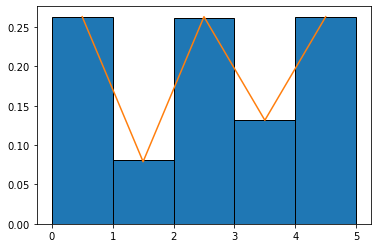

Results of Activity #3
[0.26315789 0.07894737 0.26315789 0.13157895 0.26315789]


As we can see, the relative frequencies have almost the same values of the stationary distribution


In [37]:
import matplotlib.pyplot as plt

def to_int(vec):
    res = []
    for i in range(len(vec)):
        res.append(int(vec[i]))
    return res

M = load_chain()
u_star = stationary_dist(M)
nS = len(M[0])
u = np.ones((1, nS)) / nS
traj = simulate(M, u, 10000) 
xbins = []
xx = []
yy = []

for i in range(nS):
    xx.append(i+0.5)
    yy.append(u_star[i])

for i in range(nS+1):
    xbins.append(i)

plt.hist(to_int(traj), bins=xbins, density=1, ec='black')
plt.plot(x, y)
plt.show()

print("Results of Activity #3")
print(u_star)
print("\n")
print("As we can see, the relative frequencies have almost the same values of the stationary distribution")
